In [1]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [17]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data_tut/names/*.txt'))

import unicodedata
import string

import torch
import torch.nn as nn

import random

['data_tut/names\\Arabic.txt', 'data_tut/names\\Chinese.txt', 'data_tut/names\\Czech.txt', 'data_tut/names\\Dutch.txt', 'data_tut/names\\English.txt', 'data_tut/names\\French.txt', 'data_tut/names\\German.txt', 'data_tut/names\\Greek.txt', 'data_tut/names\\Irish.txt', 'data_tut/names\\Italian.txt', 'data_tut/names\\Japanese.txt', 'data_tut/names\\Korean.txt', 'data_tut/names\\Polish.txt', 'data_tut/names\\Portuguese.txt', 'data_tut/names\\Russian.txt', 'data_tut/names\\Scottish.txt', 'data_tut/names\\Spanish.txt', 'data_tut/names\\Vietnamese.txt']


In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data_tut/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Slusarski


In [7]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [8]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [11]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [14]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [15]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9041, -2.9269, -2.8868, -2.9844, -2.8255, -2.8449, -2.9246, -2.8387,
         -2.9741, -2.9317, -2.8783, -2.9735, -2.8392, -2.7780, -2.9124, -2.8225,
         -2.8546, -2.9577]], grad_fn=<LogSoftmaxBackward0>)


In [16]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 13)


In [18]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Jager
category = Arabic / line = Nader
category = Korean / line = Nam
category = Italian / line = Abello
category = Spanish / line = Gomez
category = Irish / line = Riagain
category = Portuguese / line = Duarte
category = Portuguese / line = Nunes
category = Japanese / line = Imoo
category = Dutch / line = Pender


In [19]:
criterion = nn.NLLLoss()

In [20]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [21]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

In [22]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 1.9688 Shim / Korean ✓
10000 10% (0m 18s) 2.0658 Crespo / Portuguese ✓
15000 15% (0m 27s) 2.7656 David / Arabic ✗ (French)
20000 20% (0m 36s) 2.1677 Madaidhin / Russian ✗ (Irish)
25000 25% (0m 45s) 1.6134 Clark / Scottish ✓
30000 30% (0m 54s) 0.7289 Eng / Chinese ✓
35000 35% (1m 2s) 1.6481 Deniel / French ✓
40000 40% (1m 11s) 0.0878 Christodoulou / Greek ✓
45000 45% (1m 20s) 1.6319 Li / Vietnamese ✗ (Korean)
50000 50% (1m 28s) 0.8434 Cha / Korean ✓
55000 55% (1m 40s) 2.6911 Seger / German ✗ (Czech)
60000 60% (1m 52s) 2.5134 Nieddu / Irish ✗ (Italian)
65000 65% (2m 4s) 4.4971 Jagoda / Japanese ✗ (Polish)
70000 70% (2m 14s) 0.7610 Ferreiro / Portuguese ✓
75000 75% (2m 25s) 2.1918 Lauwens / Scottish ✗ (Dutch)
80000 80% (2m 35s) 0.5761 Szwedko / Polish ✓
85000 85% (2m 45s) 0.6211 Agrioli / Italian ✓
90000 90% (2m 55s) 0.4697 Shuo / Chinese ✓
95000 95% (3m 4s) 1.2919 Moghadam / Greek ✗ (Arabic)
100000 100% (3m 13s) 3.8589 Newham / Vietnamese ✗ (English)


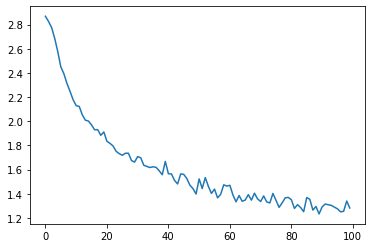

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\mgwei\AppData\Local\Temp/ipykernel_18308/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\mgwei\AppData\Local\Temp/ipykernel_18308/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


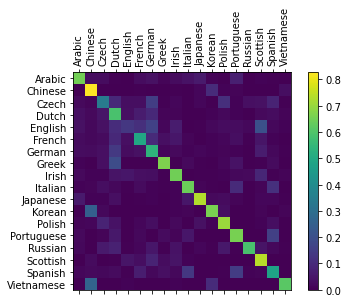

In [24]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [25]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.54) Czech
(-1.26) Russian
(-2.47) Polish

> Jackson
(-0.21) Scottish
(-2.63) English
(-3.30) Czech

> Satoshi
(-0.63) Arabic
(-1.55) Japanese
(-2.80) Italian


In [38]:
predict('ian')


> ian
(-0.58) Chinese
(-2.16) Irish
(-2.88) French
